In [1]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
from skimage import measure
from skimage.measure import regionprops
import pandas as pd

In [2]:
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])

    tiff_sequence = tifffile.TiffSequence(tiff_files)
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)

In [3]:
ut_folder = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Panel PEGASO\probetas\1\26')
ut_files = list(ut_folder.glob('*.tif'))
print(ut_files)
ut_rf = tifffile.imread(ut_files[1])
ut_amp = tifffile.imread(ut_files[2])

[WindowsPath('//192.168.10.106/imdea/DataDriven_UT_AlbertoVicente/03_UT_data/Panel PEGASO/probetas/1/26/26.tif'), WindowsPath('//192.168.10.106/imdea/DataDriven_UT_AlbertoVicente/03_UT_data/Panel PEGASO/probetas/1/26/26_aligned.tif'), WindowsPath('//192.168.10.106/imdea/DataDriven_UT_AlbertoVicente/03_UT_data/Panel PEGASO/probetas/1/26/26_amplitude.tif')]


In [4]:
xct_folder = Path(r'Q:\11_AIRBUS\03_LabXCT\Panel Pegaso\Probetas\1\26\output\segmentation')

onlypores = read_sequence(xct_folder / 'onlypores').astype(bool)
mask = read_sequence(xct_folder / 'sample_mask').astype(bool)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Q:\\11_AIRBUS\\03_LabXCT\\Panel Pegaso\\Probetas\\1\\26\\output\\segmentation\\onlypores'

In [185]:
max_proj = np.max(mask, axis=0)

labels = measure.label(max_proj)

props = regionprops(labels)

minr_xct, minc_xct, maxr_xct, maxc_xct = props[0].bbox

#crop the volume

mask_cropped = mask[:, minr_xct:maxr_xct, minc_xct:maxc_xct]
onlypores_cropped = onlypores[:, minr_xct:maxr_xct, minc_xct:maxc_xct]

print(mask_cropped.shape, onlypores_cropped.shape)

(350, 3042, 1656) (350, 3042, 1656)


In [186]:
ut_resolution = 1 #mm
xct_resolution = 0.025 #mm

In [187]:
# Calculate scaling factor
scaling_factor = xct_resolution / ut_resolution

# Convert bounding box to UT resolution
minr_ut = int(minr_xct * scaling_factor)
minc_ut = int(minc_xct * scaling_factor)
maxr_ut = int(maxr_xct * scaling_factor)
maxc_ut = int(maxc_xct * scaling_factor)

print(minr_ut, minc_ut, maxr_ut, maxc_ut)

ut_rf_cropped = ut_rf[:,minr_ut:maxr_ut, minc_ut:maxc_ut]
ut_amp_cropped = ut_amp[:,minr_ut:maxr_ut, minc_ut:maxc_ut]

print(ut_rf_cropped.shape, ut_amp_cropped.shape)

30 21 106 62
(448, 76, 41) (448, 76, 41)


In [188]:
import numpy as np
from skimage.util import view_as_windows

def divide_into_patches(image, patch_size, step_size):
    patches = view_as_windows(image, (image.shape[0], patch_size, patch_size), step=(image.shape[0], step_size, step_size))
    return patches.reshape(-1, image.shape[0], patch_size, patch_size)

def calculate_patch_shape(image_shape, patch_size, step_size):
    # Calculate the number of patches along each dimension
    num_patches_h = ((image_shape[1] - patch_size) // step_size) + 1
    num_patches_w = ((image_shape[2] - patch_size) // step_size) + 1

    # The outgoing shape would be (num_patches_h, num_patches_w, image_shape[0], patch_size, patch_size)
    return (num_patches_h * num_patches_w, image_shape[0], patch_size, patch_size)


def calculate_pixels(ut_resolution, xct_resolution, ut_pixels):
    # Calculate the ratio of the resolutions
    resolution_ratio = ut_resolution /xct_resolution 
    
    # Calculate the equivalent number of pixels in the xct resolution
    xct_pixels = ut_pixels * resolution_ratio
    
    return xct_pixels

def crop_image_to_patch_size(image, patch_size):
    z, x, y = image.shape

    crop_x = x % patch_size
    crop_y = y % patch_size

    crop_x_before = crop_x // 2
    crop_x_after = crop_x - crop_x_before

    crop_y_before = crop_y // 2
    crop_y_after = crop_y - crop_y_before

    cropped_image = image[:, crop_x_before:-crop_x_after or None, crop_y_before:-crop_y_after or None]

    return cropped_image

In [189]:
ut_patch_size = 3
ut_step_size = 1
xct_patch_size = int(np.round(calculate_pixels(ut_resolution, xct_resolution, ut_patch_size)))
xct_step_size = int(np.round(calculate_pixels(ut_resolution, xct_resolution, ut_step_size)))
print(xct_patch_size, xct_step_size)

120 40


In [190]:
ut_amp_cropped = crop_image_to_patch_size(ut_amp_cropped, ut_patch_size)
ut_rf_cropped = crop_image_to_patch_size(ut_rf_cropped, ut_patch_size)
onlypores_cropped = crop_image_to_patch_size(onlypores_cropped, xct_patch_size)
mask_cropped = crop_image_to_patch_size(mask_cropped, xct_patch_size)
print(ut_amp_cropped.shape,ut_rf_cropped.shape, onlypores_cropped.shape, mask_cropped.shape)

(448, 75, 39) (448, 75, 39) (350, 3000, 1560) (350, 3000, 1560)


In [191]:
ut_shape = calculate_patch_shape(ut_rf_cropped.shape, ut_patch_size, ut_step_size)
xct_shape = calculate_patch_shape(onlypores_cropped.shape, xct_patch_size, xct_step_size)
print(ut_shape, xct_shape)

(2701, 448, 3, 3) (2701, 350, 120, 120)


In [192]:
patches_ut = divide_into_patches(ut_rf_cropped, ut_patch_size, ut_step_size)
patches_ut_amp = divide_into_patches(ut_amp_cropped, ut_patch_size, ut_step_size)

In [193]:
patches_onlypores = divide_into_patches(onlypores_cropped, xct_patch_size, xct_step_size)
patches_mask = divide_into_patches(mask_cropped,xct_patch_size, xct_step_size)

In [194]:
print(patches_ut.shape, patches_onlypores.shape, patches_mask.shape)

(2701, 448, 3, 3) (2701, 350, 120, 120) (2701, 350, 120, 120)


In [247]:
#compute the sum of onlypores and mask

sum_onlypores_patches = np.sum(patches_onlypores, axis = 1)
sum_mask_patches = np.sum(patches_mask, axis = 1)


print(sum_onlypores_patches.shape, sum_mask_patches.shape)

(2701, 120, 120) (2701, 120, 120)


In [248]:
import numpy as np
import matplotlib.pyplot as plt

def plot_patch_signals(patch):
    # Ensure the patch is square-shaped
    if patch.shape[1] != patch.shape[2]:
        raise ValueError("Patch must be square-shaped")
    
    signal_length, patch_x, patch_y = patch.shape
    
    # Create a figure with subplots arranged in a patch_x by patch_y grid
    fig, axs = plt.subplots(patch_x, patch_y, figsize=(patch_y * 2, patch_x * 2))
    
    # Flatten the axs array for easy iteration if it's multidimensional
    if patch_x > 1 and patch_y > 1:
        axs = axs.flatten()
    
    # Iterate over each signal in the patch and plot it
    for i in range(patch_x):
        for j in range(patch_y):
            ax = axs[i * patch_y + j] if patch_x > 1 and patch_y > 1 else axs
            ax.plot(patch[:, i, j])
            ax.set_title(f"Signal ({i},{j})")
            ax.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

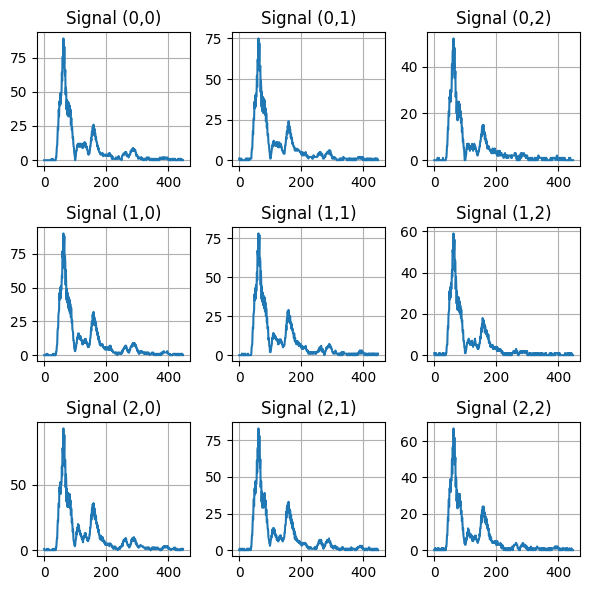

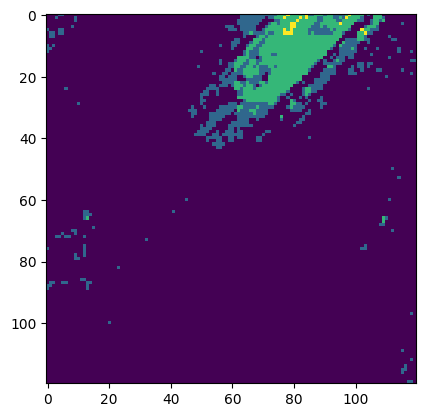

In [249]:
plot_patch_signals(patches_ut_amp[110])
plt.imshow(sum_onlypores_patches[110])

In [325]:
#volfrac for patch vs volfrac dataset

sum_onlypores = np.sum(sum_onlypores_patches, axis = (1,2)).astype(np.int16)
sum_mask = np.sum(sum_mask_patches, axis = (1,2))

#the points that are zero in the mask are not material, so we set them to -1e-6 in onlypores to know that they are not material

zero_indices = np.where(sum_mask == 0)

volfrac = sum_onlypores / (sum_mask + 1e-6)

volfrac[zero_indices] = -1

In [349]:
#volfrac for patch vs volfrac patch dataset

zero_indices = np.where(sum_mask_patches == 0)

volfrac_patches = sum_onlypores_patches / (sum_mask_patches + 1e-6)

volfrac_patches[zero_indices] = -1

volfrac_patches = volfrac_patches.reshape(-1, volfrac_patches.shape[1] * volfrac_patches.shape[2])

print(volfrac_patches.shape)

(2701, 14400)


In [331]:
#prepare ut for dataframe

ut_patches_reshaped = patches_ut.transpose(0, 2, 3, 1)

ut_amp_patches_reshaped = patches_ut_amp.transpose(0, 2, 3, 1)

ut_patches_reshaped = ut_patches_reshaped.reshape(ut_patches_reshaped.shape[0], -1)

ut_amp_patches_reshaped = ut_amp_patches_reshaped.reshape(patches_ut_amp.shape[0], -1)

combined_ut = np.hstack((ut_patches_reshaped, ut_amp_patches_reshaped))

print(combined_ut.shape)

(2701, 8064)


In [350]:
#create both dataframes

#column names for ut

columns_ut = []

half = combined_ut.shape[1] // 2

for i in range(combined_ut.shape[1]):
    if i < half:
        columns_ut.append(f'ut_rf_{i}')
    else:
        columns_ut.append(f'ut_amp_{i - half}')

columns_ut = np.array(columns_ut)

#dataframe for patch vs volfrac dataset

patch_vs_volfrac = np.hstack((combined_ut, volfrac.reshape(-1,1)))

print(patch_vs_volfrac.shape)

df_patch_vs_volfrac = pd.DataFrame(patch_vs_volfrac, columns = np.append(columns_ut, 'volfrac'))


(2701, 8065)


In [352]:

#column names for volfrac patches dataframes
columns_volfrac = []

for i in range(volfrac_patches.shape[1]):
    columns_volfrac.append(f'volfrac_{i}')

columns_volfrac = np.array(columns_volfrac)

#dataframe for patch vs volfrac patch dataset

patch_vs_patch = np.hstack((combined_ut, volfrac_patches))

print(patch_vs_patch.shape)

columns = np.append(columns_ut, columns_volfrac)

df_patch_vs_patch = pd.DataFrame(patch_vs_patch, columns = columns)

(2701, 22464)


,ut_rf_0,ut_rf_1,ut_rf_2,ut_rf_3,ut_rf_4,ut_rf_5,ut_rf_6,ut_rf_7,ut_rf_8,ut_rf_9,...,volfrac_14390,volfrac_14391,volfrac_14392,volfrac_14393,volfrac_14394,volfrac_14395,volfrac_14396,volfrac_14397,volfrac_14398,volfrac_14399
0,128.0,129.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128.0,129.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,128.0,128.0,128.0,128.0,128.0,129.0,128.0,128.0,128.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,128.0,128.0,128.0,128.0,128.0,129.0,128.0,128.0,128.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,128.0,128.0,129.0,129.0,128.0,128.0,129.0,129.0,128.0,129.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [280]:
import numpy as np
import matplotlib.pyplot as plt

def plot_array_statistics(arr):
    """
    Given a 1D numpy array, this function creates a figure with three subplots:
    1. A histogram of the values
    2. A scatter plot of the values against their index
    3. A box plot of the values
    
    Parameters:
    - arr: A 1D numpy array of values
    
    Returns:
    None
    """
    if not isinstance(arr, np.ndarray) or arr.ndim != 1:
        raise ValueError("Input must be a 1D numpy array.")
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Histogram
    axs[0].hist(arr, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_title('Histogram')
    
    # Scatter Plot
    axs[1].scatter(range(len(arr)), arr, color='red')
    axs[1].set_title('Scatter Plot')
    
    # Box Plot
    axs[2].boxplot(arr, vert=False)
    axs[2].set_title('Box Plot')
    
    plt.tight_layout()
    plt.show()